In [ ]:
# installs
import Pkg; Pkg.add("JSON")

In [ ]:
Pkg.add("Plots")

In [1]:
import(JSON)
import(Plots)

In [ ]:
using(BenchmarkTools)

In [ ]:
#include("./graph_force.jl")

In [2]:
mutable struct Graph
    chains::Array{Array{String,1},1}
    nodes::Dict{String,Int64}
    coords::Union{Nothing, Array{Float64,2}}
end

function printinfo(x::Graph)
    println(length(x.nodes), " nodes")
    println(length(x.chains), " chains")
    end;

# Search for intersections
# i.e. nodes which are in more than 1 chain
function search_intersections(graph)
    intersections = Dict()
    for (ch_idx, ch) in enumerate(graph.chains), n in ch
        el = get!(intersections, n, Int64[])
        push!(el, ch_idx)
        end;

    filter!(x -> length(x[2]) > 1, intersections);
    return intersections
    end;

# Search for intersecting chains
# i.e. returns index of the crossed chains
function search_chain_intersected(graph, chain_id)
    chain = graph.chains[chain_id]
    intersections = search_intersections(graph)
    intersected = Set{Int64}()
    for n in chain
        union!(intersected, get(intersections, n, []))
        end;
    setdiff!(intersected, chain_id)
    return collect(intersected)
    end;


In [3]:
# from node key (string) to index, to coords
function get_coords(graph, n)
    return graph.coords[[1, 2], graph.nodes[n]]
    end;

In [4]:
# Lagrange interpolation
function Lagrange_interpolation(knots, new_x)
    quotient(j, x, m) = if (j != m); (x - knots[m][1])/(knots[j][1] - knots[m][1]) else 1 end;
    el(j, x) = prod(m -> quotient(j, x, m), 1:length(knots))
    L(x) = sum(j -> knots[j][2].*el(j, x), 1:length(knots))
    return L.(new_x);
    end;

# test
#x = range(1, 6, step=1)
#Lagrange_interpolation([(3, [2, 2]), (5, [3, 4])], x)

# Place the first chain
# Returns a new graph (with one chain)
function init_graph(first_chain) 

    node_distance = 1.0
    nodes =  Dict(n => i
                    for (i, n) in enumerate(first_chain))
    coords = hcat([[node_distance*(i-1); 0] for i in 1:length(nodes)]...)
    return Graph([first_chain], nodes, coords)
    end;

# Add a chain to the graph
function add_a_chain!(graph, chain)
    # Search for knots, i.e. nodes already in the new graph
    knots = filter(x -> x in keys(graph.nodes), chain)

    println("number of knots: ", length(knots))
    if length(knots)==0;  error("zero intersection") end;

    # convert knots to [(position, Coords), ...]
    knots = map(n->(findfirst(isequal(n), chain), get_coords(graph, n)),  knots)

    # si un seul noeud...
    # choisir une direction "perpendiculaire"
    # cas si une seule chaine rencontrée
    # find nodes avant et après de cette chaine rencontrée
    if length(knots)==1
        idx_along_chain = knots[1][1]
        n = chain[idx_along_chain]

        other_chain_id = findfirst(ch -> n in ch, graph.chains)
        other_chain = graph.chains[other_chain_id]
        idx_along_other_chain = findfirst(isequal(n), other_chain)

        println("intersection with chain #", other_chain_id,
            " at node #", idx_along_other_chain)

        # Define a normal direction
        # take next or previous node (edge cases)
        if idx_along_other_chain == 1
            before = get_coords(graph, other_chain[1])
            next = get_coords(graph, other_chain[2])
        else
            before = get_coords(graph, other_chain[idx_along_other_chain-1])
            next = get_coords(graph, other_chain[idx_along_other_chain])
            end;

        # normal direction:
        u = next .- before
        norm = sqrt(u[1]^2 + u[2]^2) *.87242*length(chain)  # hack to prevent overlaping
        direction = [u[2]/norm; -u[1]/norm]

        # ajoute un noeud
        # si ce n'est pas le dernier alors le suivant
        # sinon le precedent
        # TODO: make a random choice, left or right?
        coords_n = knots[1][2]
        if idx_along_chain < length(chain)
            push!(knots, (idx_along_chain+1, coords_n .+ direction))
        else
            push!(knots, (idx_along_chain-1, coords_n .- direction))
            end;
        end;

    # Interpolation
    x = range(1, length(chain), step=1)
    coords = Lagrange_interpolation(knots, x)
    # Update the graph ... no memory optimi
    push!(graph.chains, chain)
    N = size(graph.coords)[2]
    for (i, (n, xy)) in enumerate(zip(chain, coords))
        graph.nodes[n] = N+i
        end;
    graph.coords = hcat(graph.coords, coords...)
    end;

In [6]:
# Graph the graph
function graphplot(graph::Graph)
    fig = Plots.plot(legend=false, aspect_ratio=:equal)
    #scatter!(coords[:, 1], coords[:, 2], linewidth=2)
    for chain in graph.chains
        chain_xy = map(x -> graph.coords[[1, 2], graph.nodes[x]], chain);
        x = getindex.(chain_xy, 1)
        y = getindex.(chain_xy, 2)
        Plots.plot!(x, y, linewidth=3)
        #println(coords[idx, 1])
        end;
    fig
    end;

In [11]:
# Add a chain using "Lagragne interpolation"
# update graph building infos
function place_next_chain!(graph, chains_to_add, added_chain, fullgraph)
    next_chain_id = pop!(chains_to_add)
    next_chain = fullgraph.chains[next_chain_id]
    println("add chain #", next_chain_id, " of length ", length(next_chain))
    add_a_chain!(graph, next_chain)

    # update records
    push!(added_chain, next_chain_id)
    println("added chain ", added_chain, " check ", length(graph.chains))

    new_chains_to_add = search_chain_intersected(fullgraph, next_chain_id);
    println("all new chain ", new_chains_to_add)
    append!(chains_to_add, filter(x -> ~(x in added_chain)&~(x in chains_to_add), new_chains_to_add))
    sort!(chains_to_add, by=x->length(fullgraph.chains[x]), rev=false) # add short first (false)
    println("chains_to_add  ", chains_to_add)

    println(length(graph.nodes), " nodes/ ", length(fullgraph.nodes))
    end;

In [13]:
# ====================
# Load graph from Json
files = filter(x -> endswith(x, ".json"), readdir("json/"))

3-element Array{String,1}:
 "069833931_1557.json"
 "069833931_2343.json"
 "069833931_812.json" 

In [14]:
path = string("./json/", files[1])
data = read(path, String)
d = []
chains = JSON.parse( data, dicttype=Array{Array{String}});
sort!(chains, by=x->length(x), rev=true)
println("number of chains: ", length(chains))

number of chains: 249


In [15]:
# Define the (entire) graph
nodes_list = unique(n for ch in chains for n in ch)
nodes = Dict( n=>k for (k, n) in enumerate(nodes_list) )

fullgraph = Graph(chains, nodes, nothing);
printinfo(fullgraph)

1712 nodes
249 chains


In [16]:
intersections = search_intersections(fullgraph)
println(length(intersections), " intersections")

335 intersections


In [17]:
# Start building the new graph
graph = init_graph(fullgraph.chains[1]);
added_chain = [1, ]
chains_to_add = search_chain_intersected(fullgraph, 1);
println("next chains: ", chains_to_add)

next chains: [204, 210, 128, 133, 10, 186, 202, 183, 201, 139, 127, 36, 218]


add chain #218 of length 2
number of knots: 1
intersection with chain #1 at node #36
added chain [1, 218] check 2
all new chain [36, 1]
chains_to_add  [204, 210, 202, 201, 186, 183, 128, 133, 139, 127, 36, 10]
57 nodes/ 1712


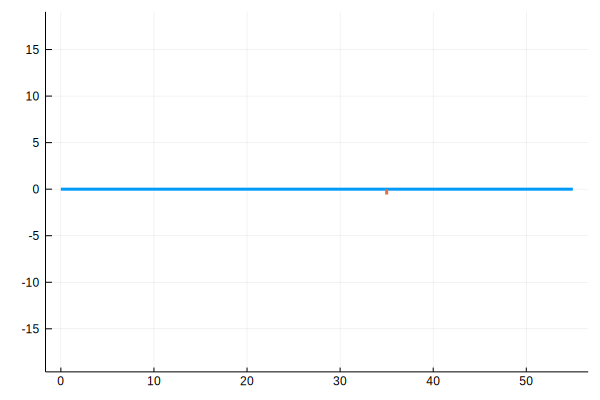

In [18]:
# Loop here
place_next_chain!(graph, chains_to_add, added_chain, fullgraph)

graphplot(graph)

In [21]:
import(Optim)

In [28]:
## Force Layout 
# Spring
function attractive_gradient(u, v)
    return (-u, -v)
    end;
function attractive_energy(u, v)
    return (u^2 + v^2)/2
    end;

# Elec
const EPSILON = 1e-4
function repulsive_energy(u, v)
    return 1/sqrt(u^2 + v^2 + EPSILON)
    end;

function repulsive_gradient(u, v)
    d = sqrt(u^2 + v^2 + EPSILON)^3
    return (u/d, v/d)
    end;

# d/dx(-1/sqrt(x^2 + y^2)) = x/(x^2 + y^2)^(3/2)

In [29]:
function graph_energy(coords, graph)
    E = 0
    # Attractive
    for chain in graph.chains
        for (n1, n2) in zip(chain[1:end-1], chain[2:end])
            i1, i2 = graph.nodes[n1], graph.nodes[n2]
            x1, y1 = coords[1, i1], coords[2, i1]
            x2, y2 = coords[1, i2], coords[2, i2]
            u = x2 - x1
            v = y2 - y1
            E += attractive_energy(u, v)
            end;
        end;
    
    # Repulsive
    # Todo: insert Barnes Hut here...
    for i in 1:length(graph.nodes)
        x1, y1 = coords[1, i], coords[2, i]
        for j in i+1:length(graph.nodes)
            x2, y2 = coords[1, j], coords[2, j]
            u = x2 - x1
            v = y2 - y1
            E += repulsive_energy(u, v)
            end;
        end;
    return E
    end;

In [30]:
graph_energy(graph.coords, graph)

337.64763346012495

In [35]:
function graph_gradient!(G, coords, graph)
    fill!(G, 0.f0)
    # Attractive
    for chain in graph.chains
        for (n1, n2) in zip(chain[1:end-1], chain[2:end])
            i1, i2 = graph.nodes[n1], graph.nodes[n2]
            x1, y1 = coords[1, i1], coords[2, i1]
            x2, y2 = coords[1, i2], coords[2, i2]
            u = x2 - x1
            v = y2 - y1
            grad = attractive_gradient(u, v)
            G[1, i1] += grad[1]
            G[2, i1] += grad[2]
            G[1, i2] -= grad[1]
            G[2, i2] -= grad[2]
            end;
        end;
    
    # Repulsive
    # Todo: insert Barnes Hut here...
    for i in 1:length(graph.nodes)
        x1, y1 = coords[1, i], coords[2, i]
        for j in i+1:length(graph.nodes)
            x2, y2 = coords[1, j], coords[2, j]
            u = x2 - x1
            v = y2 - y1
            grad = repulsive_gradient(u, v)
            G[1, i] += grad[1]
            G[2, i] += grad[2]
            G[1, j] -= grad[1]
            G[2, j] -= grad[2]
            end;
        end;
    end;

In [39]:
function optimize!(graph)
    coords = copy(graph.coords)
    G = zeros(Float32, size(coords)...)
    result = Optim.optimize(x->graph_energy(x, graph),
                            (G, x)->graph_gradient!(G, x, graph),
                            coords)

    # convert back to a "normal" graph
    graph.coords = result.minimizer;
    result
    end;

add chain #47 of length 14
number of knots: 1
intersection with chain #3 at node #5
added chain [1, 218, 10, 26, 19, 29, 13, 14, 22, 2, 15, 32, 11, 37, 8, 31, 38, 36, 42, 44, 43, 45, 47] check 23
all new chain [10, 17, 149]
chains_to_add  [223, 201, 243, 237, 230, 215, 229, 249, 200, 210, 202, 212, 211, 204, 247, 216, 234, 205, 186, 183, 194, 189, 171, 174, 173, 155, 172, 164, 151, 149, 162, 157, 139, 128, 127, 129, 138, 133, 112, 109, 122, 123, 103, 104, 93, 98, 90, 92, 74, 76, 54, 56, 52, 17]
428 nodes/ 1712
 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.67e+01, -1.47e+02, -5.69e+02,  ...]
    Minimum:   3.361269e+03

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [4.89e+01, -1.47e+02, -5.44e+02,  ...]

 * Convergence measures
    |x - x'|               = 1.16e+00 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.63e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.19e-02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.5

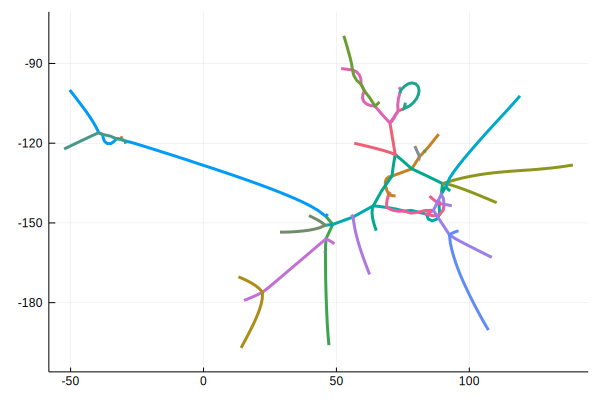

In [65]:
# Loop here
place_next_chain!(graph, chains_to_add, added_chain, fullgraph)
res = optimize!(graph)
print(res)
graphplot(graph)

add chain #45 of length 15
number of knots: 1
intersection with chain #8 at node #16
added chain [1, 218, 10, 26, 19, 29, 13, 14, 22, 2, 15, 32, 11, 37, 8, 31, 38, 36, 42, 44, 43, 45] check 22
all new chain [14]
chains_to_add  [210, 205, 234, 216, 247, 204, 211, 212, 202, 223, 200, 249, 229, 215, 230, 237, 243, 201, 186, 183, 194, 189, 164, 162, 157, 151, 172, 155, 173, 174, 171, 139, 128, 127, 129, 138, 133, 123, 122, 112, 109, 98, 103, 104, 93, 90, 92, 74, 76, 54, 56, 52, 47]
415 nodes/ 1712


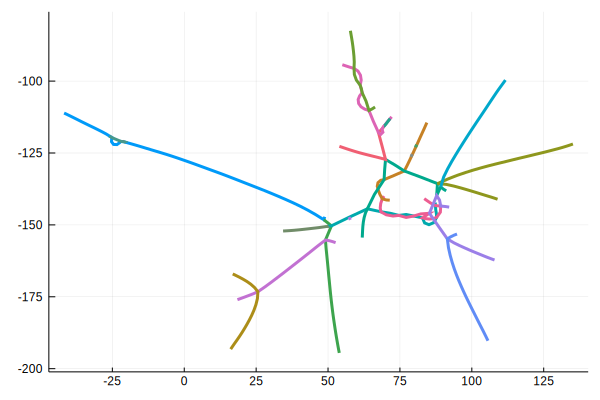

In [64]:
place_next_chain!(graph, chains_to_add, added_chain, fullgraph)
graphplot(graph)

## draft

In [ ]:
#function run_optimiz(graph)

    # Convert dict of coords to an array + dict of indexes
    nodes_idx = Dict(n => idx  for (idx, n) in enumerate(keys(graph.nodes)) );
    coords = zeros(Float32, 2, length(nodes_idx))
    for (n, idx) in pairs(nodes_idx)
        coords[:, idx] = graph.nodes[n]
        end;

    graph_solve = Graph(graph.chains, nodes_idx);

    println("graph_energy ", graph_energy(coords, graph_solve))

    coords = graph.coords
    G = zeros(Float32, size(coords)...)
    result = Optim.optimize(x->graph_energy(x, graph_solve),
                            (G, x)->graph_gradient!(G, x, graph_solve),
                            coords)

    # convert back to a "normal" graph
    coords = result.minimizer;
    nodes =  Dict(n => coords[:, idx]
                    for (n, idx) in pairs(graph_solve.nodes))

    graph = Graph(graph.chains, nodes);
    return graph
   # end;

In [ ]:
function loop!(graph)
    
    next_chain_id = pop!(chains_to_add)
    next_chain = fullgraph.chains[next_chain_id]
    println("add chain #", next_chain_id, " of length ", length(next_chain))
    add_a_chain!(graph, next_chain)

    # update records
    push!(added_chain, next_chain_id)
    println("added chain ", added_chain, " check ", length(graph.chains))

    new_chains_to_add = search_chain_intersected(fullgraph, next_chain_id);
    println("all new chain ", new_chains_to_add)
    append!(chains_to_add, filter(x -> ~(x in added_chain)&~(x in chains_to_add), new_chains_to_add))
    sort!(chains_to_add, by=x->length(fullgraph.chains[x]), rev=false)
    println("chains_to_add  ", chains_to_add)
    
    println(length(graph.nodes), " nodes/ ", length(fullgraph.nodes))
    # Optimize
    #graph = run_optimiz(graph);
    graphplot(graph)

    # loop
    end;

In [ ]:
?hcat!

In [ ]:
vcat!(graph.coords, [1; 2])

In [ ]:
loop!(graph)

In [ ]:
length(graph.nodes)

In [ ]:
graph.coords

In [ ]:
using Profile